In [2]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#Part 1:Data Preparation & Exploration

In [3]:
#load the dataset
data_time=pd.read_csv("exchange_rate.csv")

In [4]:
data_time

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [5]:
data_time.shape

(7588, 2)

In [6]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [7]:
#check the datatypes
data_time.dtypes

,0
date,object
Ex_rate,float64


In [8]:
#describe the data
data_time.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [9]:
#check the null values
data_time.isnull().sum()

,0
date,0
Ex_rate,0


In [10]:
# Print a sample of the original date column
print(data_time['date'].head())

# Apply the transformation
data_time['date'] = pd.to_datetime(data_time['date'], dayfirst=True)

# Print a sample of the transformed date column
print(data_time['date'].head())

0    01-01-1990 00:00
1    02-01-1990 00:00
2    03-01-1990 00:00
3    04-01-1990 00:00
4    05-01-1990 00:00
Name: date, dtype: object
0   1990-01-01
1   1990-01-02
2   1990-01-03
3   1990-01-04
4   1990-01-05
Name: date, dtype: datetime64[ns]


In [11]:
from pandas import to_datetime

data_time['date'] = to_datetime(data_time['date'], errors='coerce')


In [12]:
data_time.dtypes

,0
date,datetime64[ns]
Ex_rate,float64


#Visualization

**Check stationarity of the data**

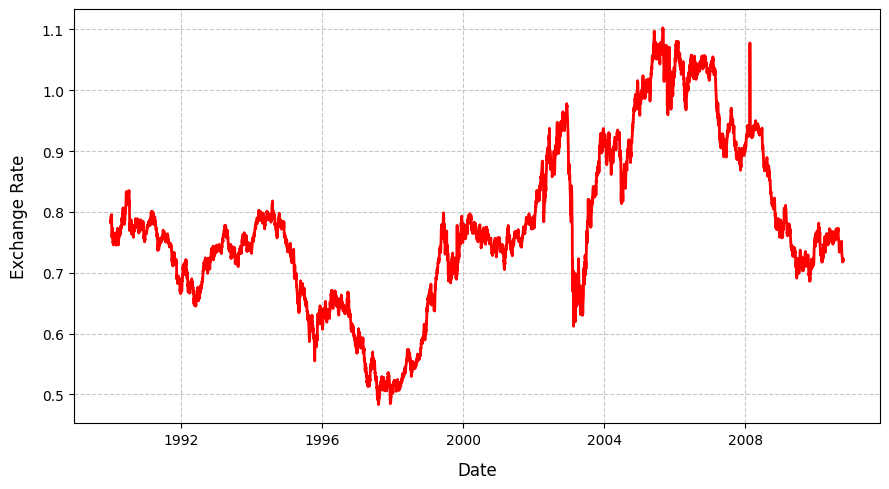

In [15]:
plt.figure(figsize=(9, 5))
plt.plot(data_time['date'], data_time['Ex_rate'], color='red', linestyle='-', linewidth=2)
plt.xlabel('Date', fontsize=12, labelpad=10)
plt.ylabel('Exchange Rate', fontsize=12, labelpad=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)  #grid style and transparency
plt.tight_layout()  # layout to avoid label overlap
plt.show()


**Plot time series for each currency**

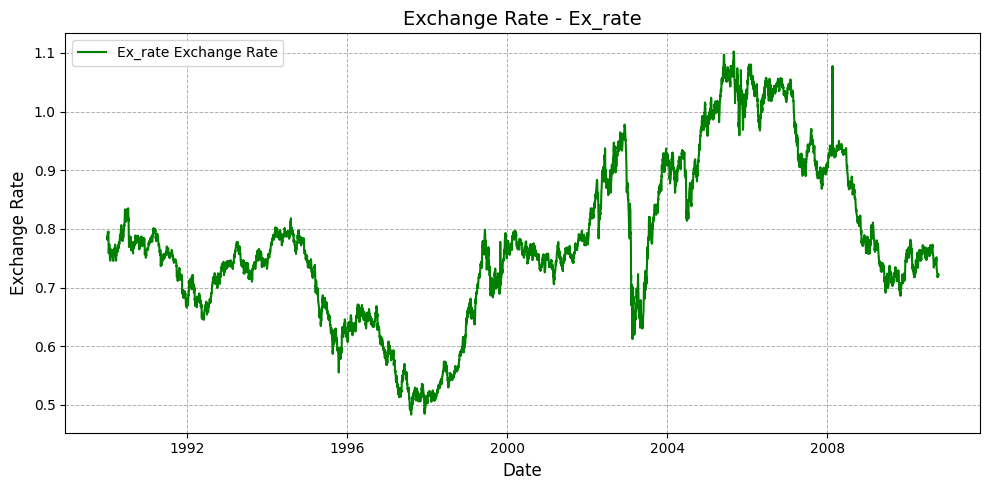

In [18]:
# Loop through each currency column and plot the exchange rates
for currency in data_time.columns[1:]:
    plt.figure(figsize=(10, 5))
    plt.plot(data_time['date'], data_time[currency], label=f"{currency} Exchange Rate", color='green')  # label for clarity
    plt.title(f"Exchange Rate - {currency}", fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Exchange Rate', fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)  # grid appearance
    plt.legend(loc='upper left')  # legend for each plot
    plt.tight_layout()
    plt.show()


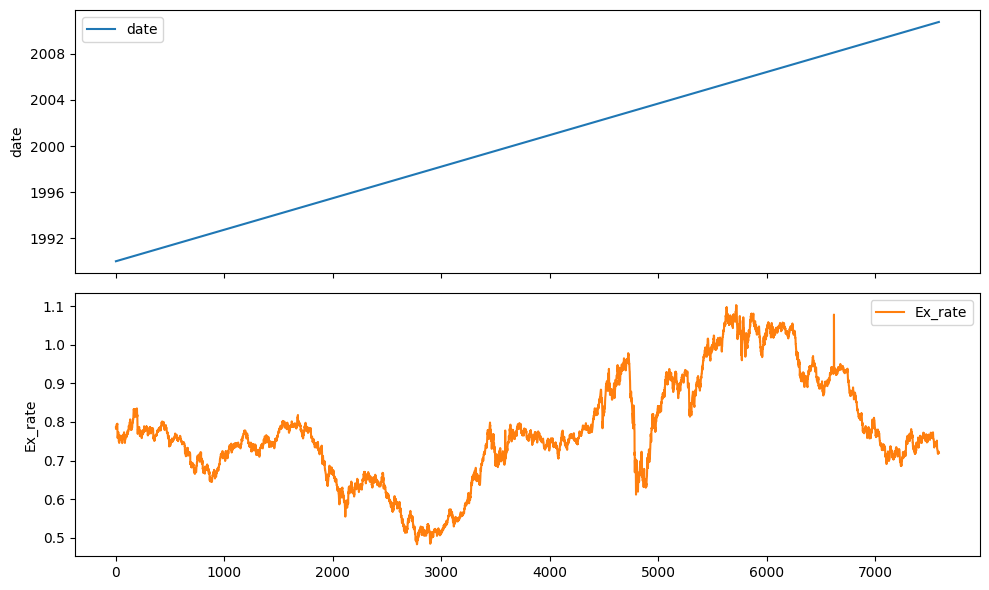

In [22]:

fig, axes = plt.subplots(nrows=len(data_time.columns), ncols=1, figsize=(10, 6), sharex=True)

# Plot each column as a subplot
for i, column in enumerate(data_time.columns):
    axes[i].plot(data_time.index, data_time[column], label=column, color='C' + str(i))
    axes[i].set_ylabel(column)
    axes[i].legend(loc='best')

# Improving the layout and showing the plot
plt.tight_layout()
plt.show()


#Part 2: Model Building - ARIMA

**ARIMA Model (Auto Regressive Integrated Moving Average)**

ARIMA model is good only on stationary dataset. It can not perform good on non-stationary dataset. For that we have 'd' parameter (differencing out) in ARIMA model which transforms non-stationary data to stationary data. Order is (p,d,q) ARIMA is composed of 3 terms(Auto-Regression(p) + Integrated(d) + Moving-Average(q))

**ACF (Autocorrelation function)** graph tells you about all the lag variables which are directly or indirectly impacting your current variable.

**PACF (Partial Autocorrelation function)** does the same as regular ACF but it shows only the direct effect and all intermediary effects are removed.

In [24]:
# Parameter Selection for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x600 with 0 Axes>

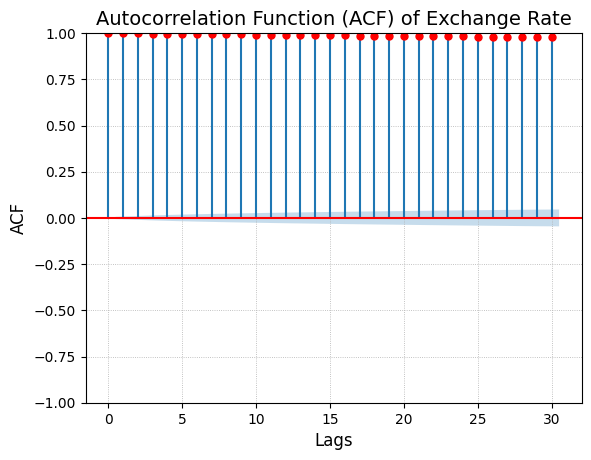

In [26]:
# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(data_time['Ex_rate'], lags=30, color='red', alpha=0.6)   #using the alpha=0.6 argument to make the plot a bit softer and less harsh visually.
plt.title('Autocorrelation Function (ACF) of Exchange Rate', fontsize=14)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('ACF', fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.show()


<Figure size 1400x700 with 0 Axes>

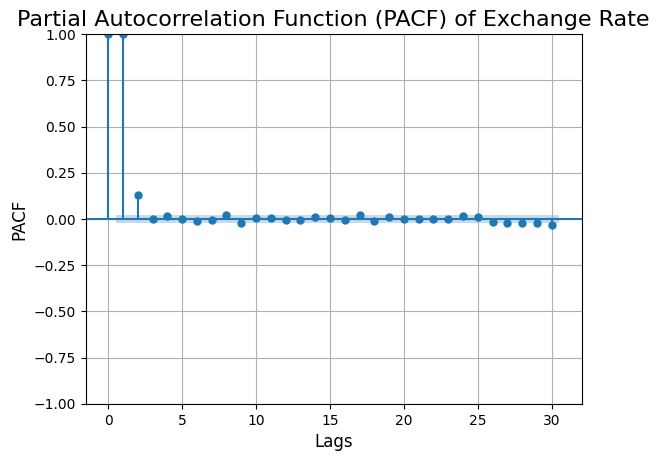

In [27]:
#PACF Plot
plt.figure(figsize=(14, 7))
plot_pacf(data_time['Ex_rate'], lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of Exchange Rate', fontsize=16)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('PACF', fontsize=12)
plt.grid(True)
plt.show()


**The Partial Autocorrelation Function (PACF)** of the exchange rate data (Ex_rate), which helps in
identifying the correlation of the data with its own past values while adjusting for the influence of intermediate lags.
The x-axis will represent the lags, and the y-axis represents the PACF values.

**Model Fitting**

In [28]:
#Arima model
from statsmodels.tsa.arima.model import ARIMA  # ARIMA import

# Setting initial parameters
order = (1, 1, 1)

# Fit ARIMA model
try:
    model = ARIMA(data_time['Ex_rate'], order=order)
    model_fit = model.fit()

    # Display the summary of the fitted model
    print(model_fit.summary())
except Exception as e:
    print(f"Error fitting the ARIMA model: {e}")


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 10 Oct 2024   AIC                         -56102.322
Time:                        04:37:53   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

#Diagnostics

**Residuals plot**

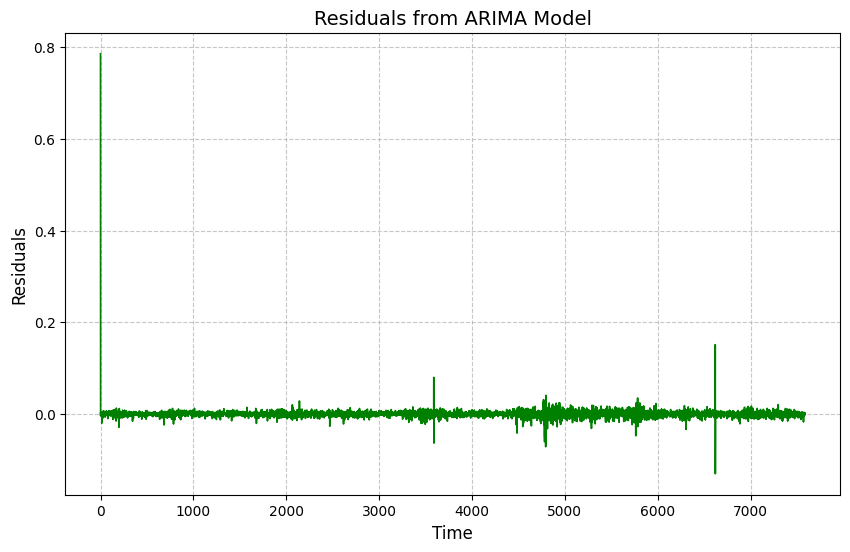

In [29]:
# Extract residuals from the model
residuals = model_fit.resid


plt.figure(figsize=(10, 6))
plt.plot(residuals, color='green', linewidth=1.2)


plt.title('Residuals from ARIMA Model', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()


**Residuals Plot:** The output is still a plot of residuals, showing the difference between the predicted values and the actual data.

**# plot ACF of residuals**

<Figure size 1000x600 with 0 Axes>

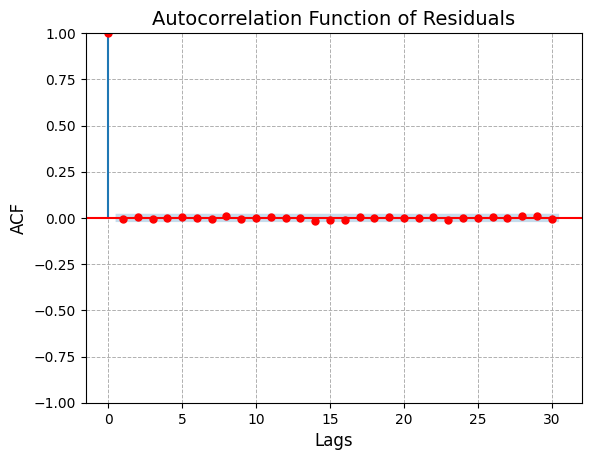

In [32]:

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=30,color="red" ,alpha=0.05)
plt.title('Autocorrelation Function of Residuals', fontsize=14)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('ACF', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()


**The Autocorrelation Function (ACF)** plot will show the correlation of the residuals at different lags.

**#plot PACF of residuals**

<Figure size 1000x600 with 0 Axes>

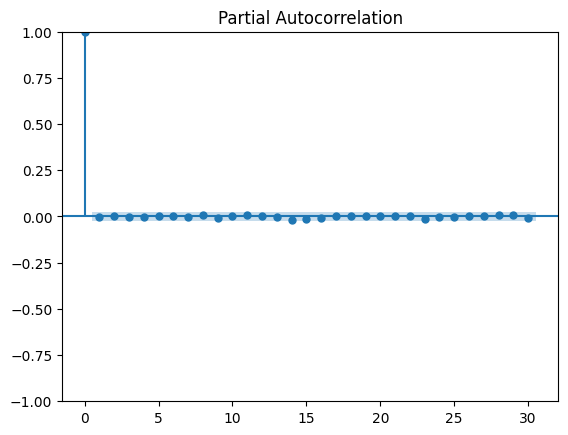

In [34]:
plt.figure(figsize=(10,6))
plot_pacf(residuals, lags=30)
plt.show()

**The PACF plot** helps identify the order of the autoregressive model (AR) in time series modeling.

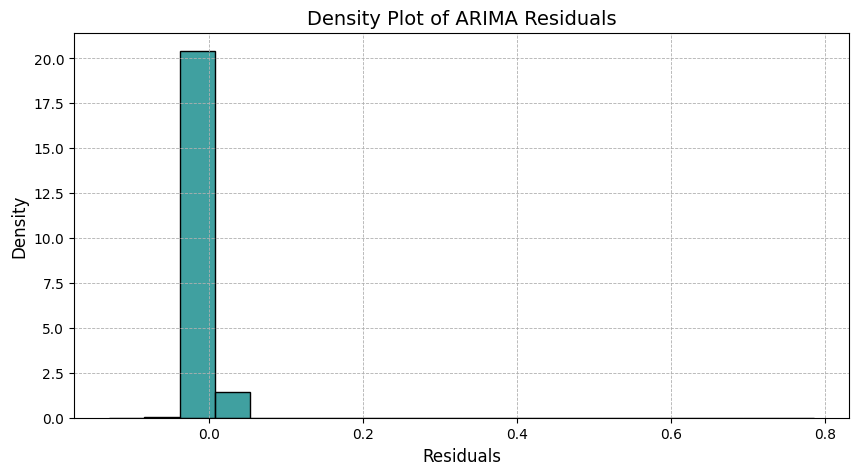

In [38]:
# Density plot of residuals

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=20, color='teal', stat='density')
plt.title('Density Plot of ARIMA Residuals', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6)
plt.show()


#Forecasting:

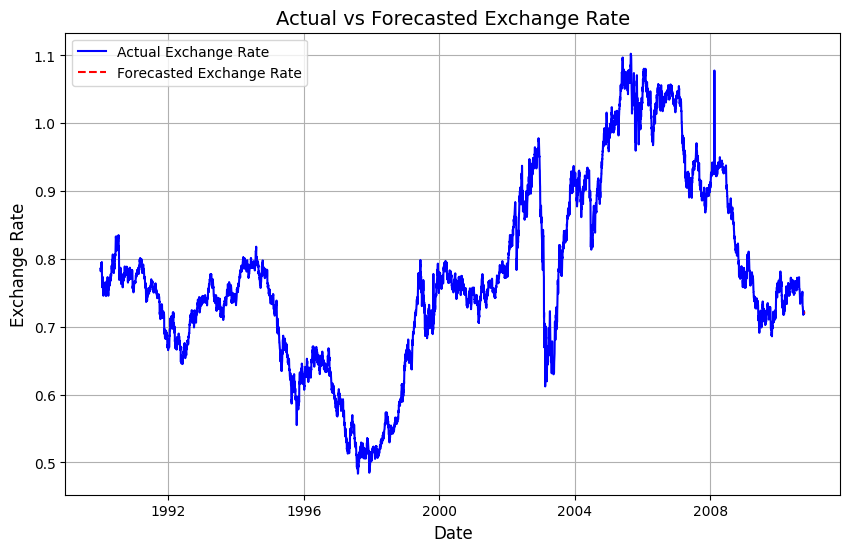

In [39]:
# Define forecast steps and calculate forecast
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Generate forecast dates
forecast_dates = pd.date_range(start=data_time['date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:]

# Plotting the actual values and forecast values
plt.figure(figsize=(10, 6))  # Slightly wider plot
plt.plot(data_time['date'], data_time['Ex_rate'], color='blue', label='Actual Exchange Rate')
plt.plot(forecast_dates, forecast, color='red', linestyle='--', label='Forecasted Exchange Rate')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.title('Actual vs Forecasted Exchange Rate', fontsize=14)
plt.legend(loc='best')

# Display the plot
plt.grid(True)
plt.show()


The blue line represents the actual exchange rate over time.
The red dashed line represents the forecasted values for the next 12 periods.

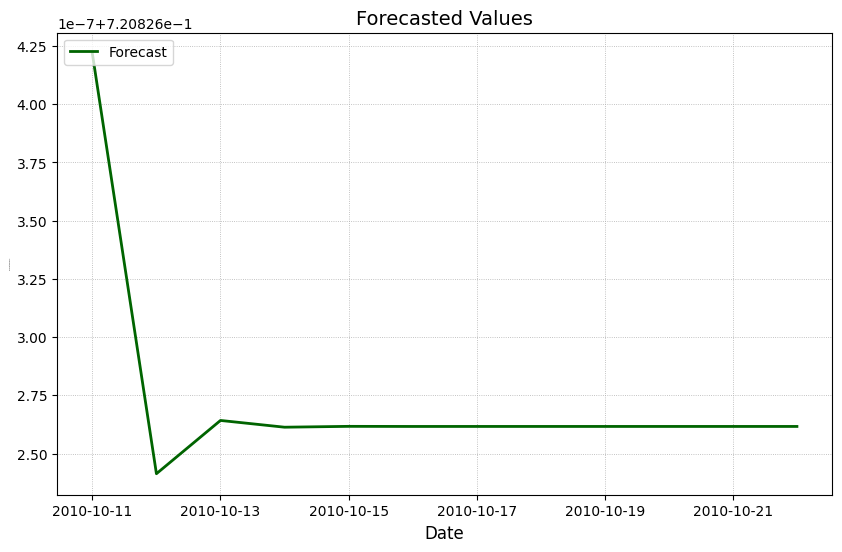

In [40]:

plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, forecast, label='Forecast', color='darkgreen', linestyle='-', linewidth=2)
plt.title('Forecasted Values', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Value', fontsize=1)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.show()


#Part 3: Model Building - Exponential Smoothing

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ex_rate_data = data_time['Ex_rate']
periods_in_season = 12  #seasonal periods parameter

model = ExponentialSmoothing(ex_rate_data, seasonal='add', seasonal_periods=periods_in_season)


In [43]:
# Fit the model
new_model = model.fit()
new_model_summary = new_model.summary()
print(new_model_summary)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.480
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Thu, 10 Oct 2024
Box-Cox:                          False   Time:                         04:55:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698356                alpha                 True
smoothing_seasonal       

In [53]:
# Perform forecasting
future_steps = 10  # Number of steps to forecast
forecast_values = model_fit.forecast(steps=future_steps)


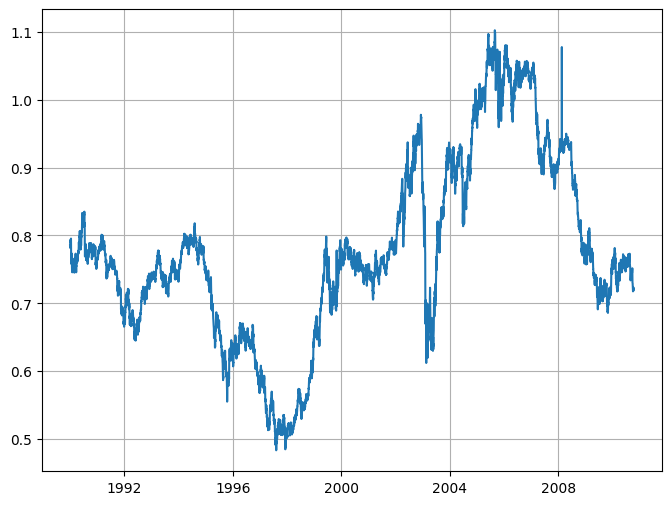

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(data_time['date'],data_time['Ex_rate'], label='Actual')
plt.grid(True)
plt.show()


#Part 4: Evaluation and Comparison

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
Mean_absolute_error = mean_absolute_error(data_time['Ex_rate'][-forecast_steps:], forecast)
root_mean_squared_error = mean_squared_error(data_time['Ex_rate'][-forecast_steps:], forecast, squared=False)

In [61]:
print(Mean_absolute_error)

0.001664492434046964


In [63]:
print(root_mean_squared_error)

0.002000358073456273


In [64]:
# Compute error metrics for Exponential Smoothing
Exponential_smoothing_MAE = mean_absolute_error(data_time['Ex_rate'][-forecast_steps:], forecast)
Exponential_smoothing_RMSE = mean_squared_error(data_time['Ex_rate'][-forecast_steps:], forecast, squared=False)

In [65]:

print("Exponential Smoothing MAE:" ,Exponential_smoothing_MAE )
print("Exponential Smoothing RMSE:" ,Exponential_smoothing_RMSE)

Exponential Smoothing MAE: 0.001664492434046964
Exponential Smoothing RMSE: 0.002000358073456273
